In [148]:
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
from src.modules.paths import get_project_root
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import wandb
import numpy as np

def load_training_and_validation():
    #pairs = ["xlmeur", "bcheur","compeur","xdgeur", "etheur", "algoeur", "bateur", "adaeur","xrpeur"]
    #df = pd.DataFrame()
    #for pair in pairs:
    #    df_aux = pd.read_csv(get_project_root() / "data" / "training" / f"{pair}_training.csv", parse_dates=["date"])
    #    df_aux["pair_name"] = pair
    #    df = pd.concat([df, df_aux])
    #df["target_5_multiplied"] = df["target_5"]*1000
    df = pd.read_feather(get_project_root() / "data" / "training" / "training_all_crypto.feather")
    #df=df[df["pair_name"]=="xlmeur"].copy()
    df["target_5_multiplied"] = df["target_5"]*1000
    return df[df.type=="training"], df[df.type=="validation"], df[df.type=="validation_unseen"]

def normalize(df, columns):
    #df = df.copy()
    #df[columns] = (df[columns]-df[columns].mean())/df[columns].std()
    return df

def get_tensors(df, feature_columns, target_name, batch_size, device, shuffle):
    if shuffle:
        df = df.sample(frac=1).copy()
    m, n = df[feature_columns].shape
    x_all = torch.Tensor(df[feature_columns].values).to(device)
    y_all = torch.Tensor(df[target_name].values).to(device)
    x = x_all.reshape([-1, batch_size, n] )
    y = y_all.reshape([-1, batch_size, 1] )
    return x, y

In [104]:
#cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def personcorr(x1, x2):
    return cos(x1 - x1.mean(dim=1, keepdim=True), x2 - x2.mean(dim=1, keepdim=True)).mean()

def corrcoef(target, pred):
    # np.corrcoef in torch from @mdo
    # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
    pred_n = pred - pred.mean()
    target_n = target - target.mean()
    pred_n = pred_n / pred_n.norm()
    target_n = target_n / target_n.norm()
    return (pred_n * target_n).sum()
def corrcoef_loss(target, pred):
    return -corrcoef(target, pred)
def corrcoef_np(target, pred):
    # np.corrcoef in torch from @mdo
    # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
    pred_n = pred - pred.mean()
    target_n = target - target.mean()
    pred_n = pred_n / np.linalg.norm(pred_n, axis=0)
    target_n = target_n / np.linalg.norm(target_n, axis=0)
    return (pred_n * target_n).sum()
def corrcoef_loss_np(target, pred):
    return -corrcoef_np(target, pred)


In [187]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torch.optim import Adam
from tqdm import tqdm

class Net2layers(nn.Module):
    def __init__(self, input_size, l1_size, l2_size):
        super(Net2layers, self).__init__()
        self.fc1 = nn.Linear(input_size, l1_size)
        self.fc2 = nn.Linear(l1_size, l2_size)
        self.fc3 = nn.Linear(l2_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, df, feature_columns, device):
        m, n = df[feature_columns].shape
        x = torch.Tensor(df[feature_columns].values).to(device)
        output = self.forward(x)
        return output.detach().cpu().numpy()
def train_pytorch(
    df_train,
    df_validation,
    df_validation_unseen,
    learning_rate,
    batch_size,
    n_iter,
    l1_size,
    l2_size,
    input_size,
    alpha,
    device,
    shuffle, 
    features, target
):
    wandb.init(config={"learning_rate": learning_rate, "l1_size": l1_size, "l2_size": l2_size, "critetion": "TripletLoss"},reinit=True, project="pytorch", entity="pab_lo4")

    
    model = Net2layers(input_size=input_size, l1_size = l1_size, l2_size=l2_size).to(device)
    wandb.watch(model, log_freq=1)
    criterion = nn.MSELoss()
    #criterion = personcorr
    optm = Adam(model.parameters(), lr = learning_rate, weight_decay=alpha)

    x, y = get_tensors(df_train,features, target, batch_size, device, shuffle=shuffle)
    x_val, y_val = get_tensors(df_validation,features, target, df_validation.shape[0], device, shuffle=shuffle)
    x_val_unseen, y_val_unseen = get_tensors(df_validation_unseen,features, target, df_validation_unseen.shape[0], device, shuffle=shuffle)
    for i in tqdm(range(n_iter)):
        for batch_id in range(x.size()[0]):

            optm.zero_grad()
            output = model(x[batch_id])
            #print(output, y[batch_id])
            loss = corrcoef_loss(output,y[batch_id])
            #print(i, loss)
            loss.backward()
            optm.step()
        #print(i, "/", n_iter)
        if i%20==0:
            wandb.log({"train_loss": loss,
                      "val_loss": corrcoef_loss(model(x_val),y_val),
                      "val_unseen_loss": corrcoef_loss(model(x_val_unseen),y_val_unseen)})
    
    return model

In [149]:
df_training_init, df_validation, df_validation_unseen = load_training_and_validation()

In [208]:
#columns_features = [col for col in df_training_init.columns if col.startswith("feature_domain")]
columns_features = [col for col in df_training_init.columns if col.startswith("feature_")]
columns_target = [col for col in df_training_init.columns if col.startswith("target")]
columns_target = ["target_5_multiplied"]

In [10]:
batch_size = 1000

In [9]:
learning_rate=0.001

n_iter = 4000
l1_size = 12
l2_size = 12
input_size = len(columns_features)
alpha = 0.0001
shuffle=True
cpu_dev = torch.device("cpu")
gpu_dev = torch.device('cuda:0')

NameError: name 'torch' is not defined

In [151]:
df_training = df_training_init.sample((df_training_init.shape[0]//batch_size)*batch_size).sample(100000)

In [299]:
df_training_norm = normalize(df_training, columns_features)
df_validation_norm = normalize(df_validation, columns_features)
df_validation_unseen_norm = normalize(df_validation_unseen, columns_features)

In [221]:
%time model = train_pytorch(df_training_norm, df_validation_norm, df_validation_unseen_norm,learning_rate, batch_size, n_iter, l1_size, l2_size, input_size, alpha, cpu_dev, shuffle, columns_features, columns_target)

train_loss,█▅▆▆▅▅▃▃▂▄▂▂▃▄▃▃▅▃▂▃▃▂▂▂▁▂▁▇▂▅▄▂▂▃▂▁▁▄▂▃
val_loss,▆▇▆▅▇▅▆██▇▆▅▇▅▄▄▃▂▂▅▃▂▃▂▂▂▂▆▂▇▇▃▄▁▂▃▃▂▂▄
val_unseen_loss,▆▅▅▆▇▅▇▇▄▅▃▆▄▅▅▂▁▅▇▅▆▇▄▅▅█▅▅▅▂▃▅▅▆▄▄▅█▄▅
train_loss,-0.1849
val_loss,-0.00023
val_unseen_loss,-0.02203


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


100%|██████████| 4000/4000 [11:10<00:00,  5.97it/s]

CPU times: user 11min 8s, sys: 2.6 s, total: 11min 10s
Wall time: 11min 19s


In [320]:
#XGB

In [2]:
from xgboost import XGBRegressor

In [214]:
#3 0.01 6000 subsample=0.8 0.001 target 5
#5 0.1 3000 0.8
# amazing performance with max depth=5, learning_rate=0.1, 3000 estimators, subsample=0.9 and all features, colsample_bytree=0.1

model = XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=5000,
    n_jobs=-1,
    subsample=0.9,
    colsample_bytree=0.1,
    verbosity=1,
    #num_paraller_tree=-1
    #objective=corrcoef_loss_np
    #gamma=0.3
)

In [190]:
#%time model.fit(df_training[columns_features], df_training[columns_target])

In [215]:
model.fit(df_training[columns_features].astype("float32"), df_training[columns_target].astype("float32"))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=1)

corr:  0.20453819197883713
r2:  -0.004583065055624003


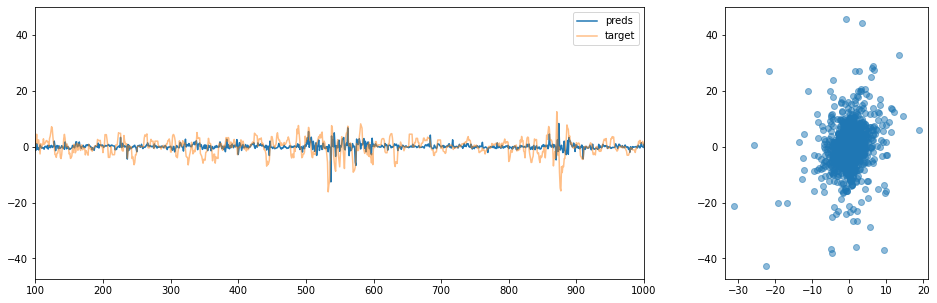

In [233]:
df_plot_val = get_df_plot(df_validation, model, pytorch=False)
df_plot_val_unseen = get_df_plot(df_validation_unseen, model, pytorch=False)
plot_results(df_plot_val, xlim=[100,1000])


corr:  0.3036915870731955
r2:  0.08393160264928645


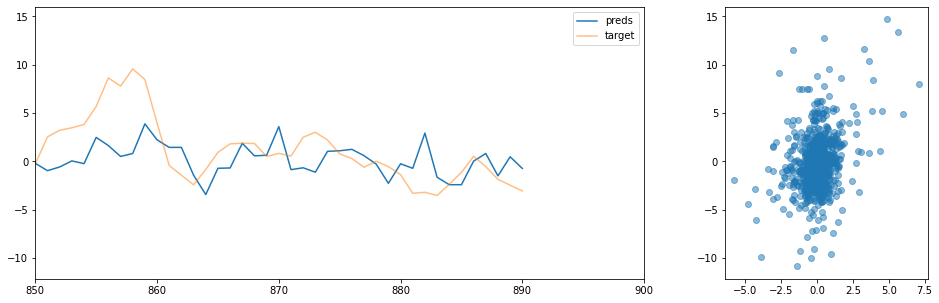

In [218]:
plot_results(df_plot_val_unseen, xlim=[850,900])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

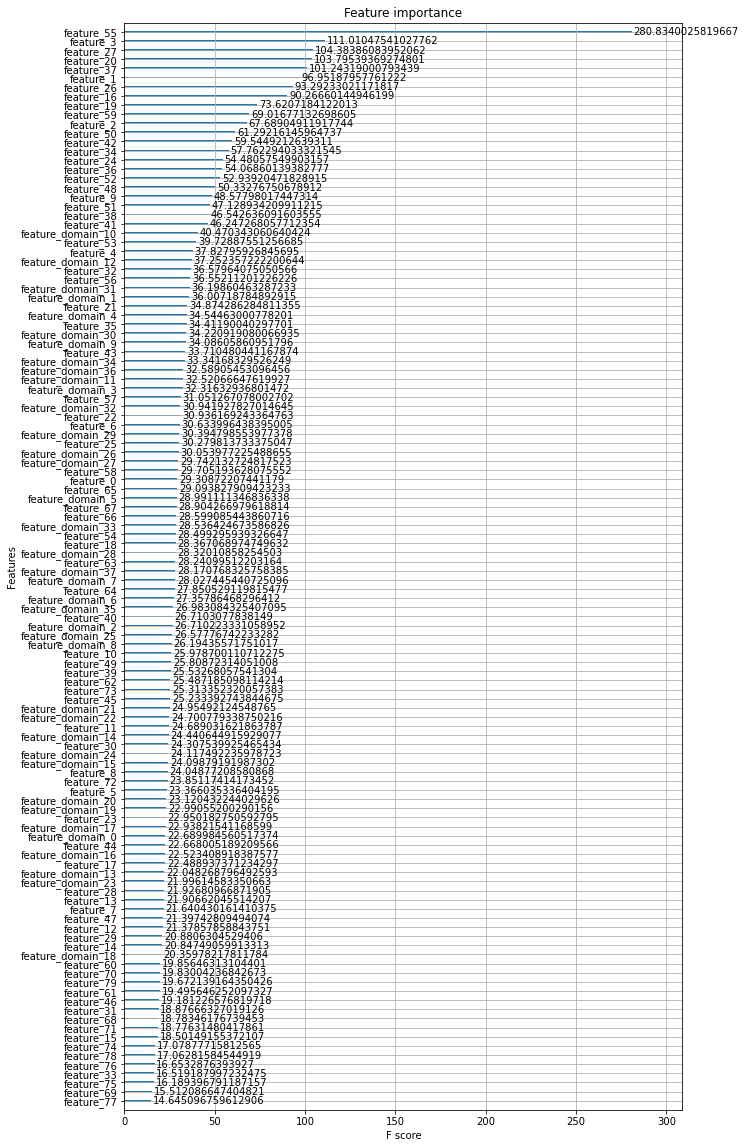

In [234]:
import xgboost
fig, ax = plt.subplots(figsize=(10, 20))
xgboost.plot_importance(model, importance_type="gain", ax=ax)
#plt.show()

In [16]:
def get_df_plot(df, model, pytorch=True):
    df_plot = df.reset_index()[columns_target].rename(columns={columns_target[0]:"target"})
    if pytorch:
        df_plot["preds"] = model.predict(df, columns_features, cpu_dev)
    else:
        df_plot["preds"] = model.predict(df[columns_features])
                                    
    return df_plot

In [205]:
feature_columns = [col for col in df_training.columns if col.startswith("feature")]

In [207]:
df_training[feature_columns]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_domain_28,feature_domain_29,feature_domain_30,feature_domain_31,feature_domain_32,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37
42730,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,0.000427,0.001506,0.000517,-0.001138,0.001103,0.008187,0.003684,0.004551,0.009406,0.008965
411908,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,0.000000,0.000000,0.000000,0.001272,-0.000172,-0.000705,0.003162,-0.002487,-0.004201,-0.013720
381620,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,-0.000225,0.000888,0.000888,0.000625,0.000000,-0.004913,-0.013916,-0.012346,-0.016063,-0.015524
534192,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,0.000284,-0.000535,-0.004283,0.001728,-0.001689,0.002605,0.004122,-0.002168,0.012278,0.010335
174508,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,-0.001992,-0.005317,-0.005317,-0.004010,-0.007288,-0.001958,-0.003204,0.009977,0.000609,0.016192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172888,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,0.000000,0.000000,0.000000,-0.003054,0.001462,0.002857,0.010618,0.023028,0.022655,0.027220
148014,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,0.000642,0.000642,0.000642,0.000642,0.000717,0.008099,0.006874,-0.007227,0.000982,-0.006781
440185,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,0.004238,0.008245,0.013512,0.004894,0.003962,0.008384,0.002366,0.036846,0.011513,0.005597
417002,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.0,0.0,...,-0.000608,-0.003227,-0.004304,-0.001624,0.001795,0.000806,-0.004776,-0.014129,-0.015915,-0.000082


In [321]:
df_plot_val = get_df_plot(df_validation_norm, model, pytorch=False)
df_plot_val_unseen = get_df_plot(df_validation_unseen_norm, model, pytorch=False)

In [266]:
x_val, y_val = get_tensors(df_validation_norm,columns_features, columns_target, df_validation.shape[0], cpu_dev, shuffle=shuffle)

In [254]:
corrcoef_loss( model(x_val), y_val)

TypeError: 'XGBRegressor' object is not callable

In [225]:
corrcoef_loss(y_val, model(x_val))

tensor(0.0713, grad_fn=<NegBackward>)

In [141]:
def plot_results(df, xlim=None):
    fig, axs = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [3, 1]})
    axs[0].plot(df["preds"], label="preds")
    axs[0].plot(df["target"],label= "target", alpha=0.5)
    if xlim:
        axs[0].set_xlim(xlim)
    axs[0].legend()
    axs[1].plot(df.preds, df.target, "o", alpha=0.5)
    print("corr: ", df.corr().values[0][1])
    print("r2: ", r2_score(df.target,df.preds ))

corr:  -0.10223026650244142
r2:  -0.01661250633694422


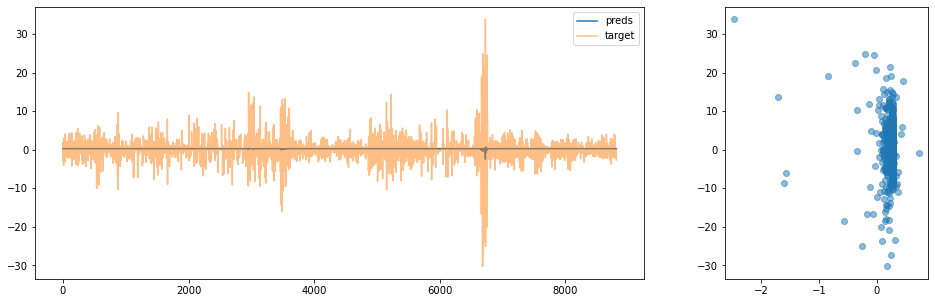

In [322]:
plot_results(df_plot_val)

corr:  0.040022524476925024
r2:  -0.02948148328735356


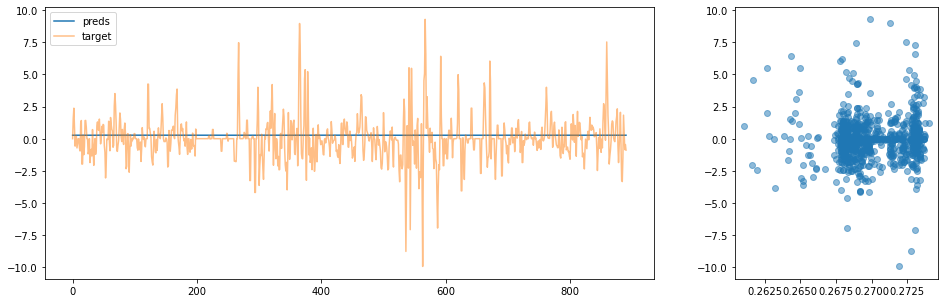

In [323]:
plot_results(df_plot_val_unseen)

In [275]:
plt.plot(model.predict(df_validation_unseen_norm, columns_features, cpu_dev), label="preds")
plt.plot(df_validation_unseen_norm.reset_index()[columns_target],label= "target")
plt.legend()
plt.xlim([550,600])

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.date, type, pair_name

In [209]:
# save
torch.save(model.state_dict(), "state_dict")

In [210]:
model_load = Net2layers(input_size=input_size, l1_size = l1_size, l2_size=l2_size)
model_load.load_state_dict(torch.load("state_dict"))
model_load.eval()

Net2layers(
  (fc1): Linear(in_features=38, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
)

In [213]:
df_plot_val = get_df_plot(df_validation_norm, model_load)
df_plot_val_unseen = get_df_plot(df_validation_unseen_norm, model_load)

corr:  0.04902704641651808
r2:  -1.56376143782485


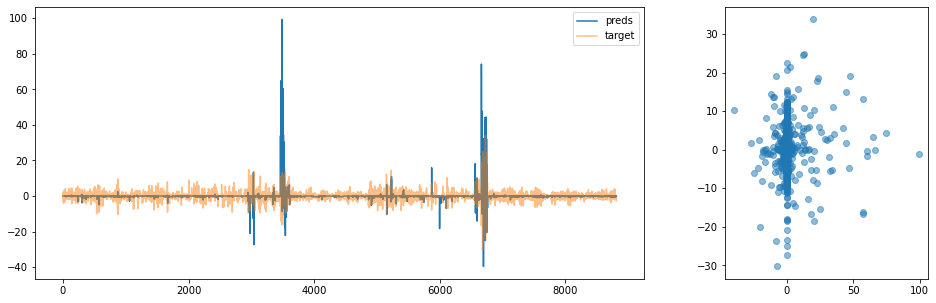

In [216]:
plot_results(df_plot_val)

In [217]:
df_plot_val.corr()

,target,preds
target,1.000000,0.049027
preds,0.049027,1.000000
